# Benchmarks

In [1]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from timeit import timeit, repeat
from pysmt.shortcuts import And, get_free_variables, get_atoms, get_formula_size, simplify

# allow Latex in text
#plt.rcParams['text.usetex'] = True

gen_kripke = importlib.import_module('track-generation-sat')
gen_exit = importlib.import_module('track-generation-grid-all')
gen_step = importlib.import_module('track-generation-grid-steps')
gen_smt = importlib.import_module('track-generation-grid-SMT')

## Performance

We will test the speed of generating a problem and solving a problem.

In [2]:
#from z3 import *
# Wrapper for allowing Z3 ASTs to be stored into Python Hashtables.
class AstRefKey:
    def __init__(self, n):
        self.n = n
    def __hash__(self):
        return self.n.hash()
    def __eq__(self, other):
        return self.n.eq(other.n)
    def __repr__(self):
        return str(self.n)

def askey(n):
    assert isinstance(n, AstRef)
    return AstRefKey(n)

def get_vars(f):
    r = set()
    def collect(f):
        if is_const(f):
            if f.decl().kind() == Z3_OP_UNINTERPRETED and not askey(f) in r:
                r.add(askey(f))
        else:
            for c in f.children():
                collect(c)
    collect(f)
    return r

### Kripke

In [6]:
# parameters for test
tests = range(2,201)
reps = 5
gen_problem_res = []
gen_solve = []
gen_variables = []

# generate and solve problem
for i in tqdm(tests):
    gen = gen_kripke.Generator(length=i)
    t = repeat(lambda: gen.generate_problem(), number=1, repeat=reps)
    gen_problem_res.append(np.mean(t))
    t = repeat(lambda: gen.get_true_literals(method='reset'), number=1, repeat=reps)
    gen_solve.append(np.mean(t))
    gen_variables.append(len(get_vars(And(gen.problem))))

100%|██████████| 199/199 [07:18<00:00,  2.21s/it]


In [7]:
#file_kripke_perf = './results/kripke_perf.csv'
#if(exists(file_kripke_perf)):
#    kripke_result = pd.read_csv(file_kripke_perf).set_index('index')

kripke_result = pd.DataFrame({'gen_problem': gen_problem_res, 'gen_solve': gen_solve, 'gen_variables': gen_variables}, index=tests)
kripke_result.to_csv('./results/kripke_perf.csv')
kripke_result

,gen_problem,gen_solve,gen_variables
2,0.002019,0.006964,10
3,0.003496,0.006958,15
4,0.004916,0.007254,20
5,0.006693,0.007452,25
6,0.009038,0.007969,30
...,...,...,...
196,0.774200,0.048413,980
197,0.784366,0.048215,985
198,0.791226,0.049835,990
199,0.792352,0.048308,995


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


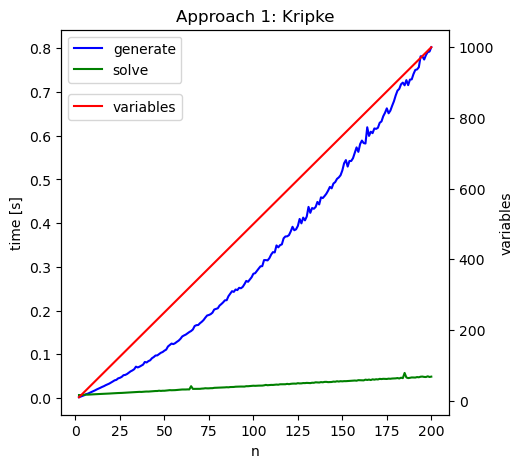

In [44]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax2 = ax.twinx()
ax.plot(kripke_result.index.tolist(),kripke_result['gen_problem'], color='b', label='generate')
ax.plot(kripke_result.index.tolist(),kripke_result['gen_solve'], color='g', label='solve')
ax2.plot(kripke_result.index.tolist(),kripke_result['gen_variables'], color='r', label='variables')
ax.set_xlabel('n')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('time [s]')
ax.set_title('Approach 1: Kripke')
ax2.set_ylabel('variables')
ax.grid(False)
ax.legend(loc="upper left")
ax2.legend(loc="upper left", bbox_to_anchor=(0.0, 0.85))
plt.savefig('./results/kripke_perf.eps',format='eps', bbox_inches='tight')

### Exit

In [2]:
# parameters for test
tests = range(2,31)
reps = 3
gen_problem_res = []
gen_solve = []
gen_variables = []

# generate and solve problem
for i in tqdm(tests):
    gen = gen_exit.Generator_grid(grid_size=(i, i))
    t = repeat(lambda: gen.generate_problem(), number=1, repeat=reps)
    gen_problem_res.append(np.mean(t))
    t = repeat(lambda: gen.get_solution(), number=1, repeat=reps)
    gen_solve.append(np.mean(t))
    vars = len(get_free_variables(And(gen.problem)))
    atoms = len(get_atoms(And(gen.problem)))
    gen_variables.append(vars)
    if vars != atoms:
        print(f'VARS != atoms for {i}')

100%|██████████| 29/29 [01:15<00:00,  2.62s/it]


In [3]:
exit_result = pd.DataFrame({'gen_problem': gen_problem_res, 'gen_solve': gen_solve,  'gen_variables': gen_variables}, index=tests)
exit_result.to_csv('./results/exit_perf.csv')
exit_result

,gen_problem,gen_solve,gen_variables
2,0.002210,0.005105,80
3,0.004462,0.007838,125
4,0.010829,0.013095,180
5,0.017186,0.015558,245
6,0.024774,0.021439,320
7,0.034744,0.026390,405
8,0.045411,0.033364,500
9,0.061476,0.041824,605
10,0.078243,0.050811,720
11,0.102056,0.061716,845


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


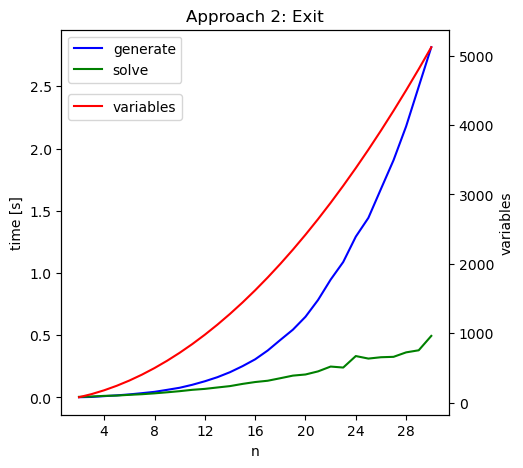

In [4]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax2 = ax.twinx()
ax.plot(exit_result.index.tolist(),exit_result['gen_problem'], color='b', label='generate')
ax.plot(exit_result.index.tolist(),exit_result['gen_solve'], color='g', label='solve')
ax2.plot(exit_result.index.tolist(),exit_result['gen_variables'], color='r', label='variables')
ax.set_xlabel('n')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('time [s]')
ax2.set_ylabel('variables')
ax.set_title('Approach 2: Exit')
ax.grid(False)
ax.legend(loc="upper left")
ax2.legend(loc="upper left", bbox_to_anchor=(0.0, 0.85))
plt.savefig('./results/exit_perf.eps',format='eps', bbox_inches='tight')

### Step

In [5]:
# parameters for test
tests = range(2,16)
reps = 3
gen_problem_res = []
gen_solve = []
gen_variables = []

# generate and solve problem
for i in tqdm(tests):
    gen = gen_step.Generator_grid(length=int(i**2/2), grid_size=(i, i))
    t = repeat(lambda: gen.generate_problem(), number=1, repeat=reps)
    gen_problem_res.append(np.mean(t))
    t = repeat(lambda: gen.get_solution(), number=1, repeat=reps)
    gen_solve.append(np.mean(t))
    vars = len(get_free_variables(And(gen.problem)))
    atoms = len(get_atoms(And(gen.problem)))
    gen_variables.append(vars)
    if vars != atoms:
        print(f'VARS != atoms for {i}')

100%|██████████| 14/14 [06:50<00:00, 29.34s/it]


In [6]:
step_result = pd.DataFrame({'gen_problem': gen_problem_res, 'gen_solve': gen_solve, 'gen_variables': gen_variables}, index=tests)
step_result.to_csv('./results/step_perf.csv')
step_result

,gen_problem,gen_solve,gen_variables
2,0.001085,0.004563,48
3,0.004309,0.013893,125
4,0.014565,0.045962,324
5,0.037032,0.113701,637
6,0.092424,0.272465,1216
7,0.225976,0.572531,2025
8,0.379750,1.169785,3300
9,0.706307,1.906772,4961
10,1.215208,3.270182,7344
11,2.024523,5.355704,10309


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


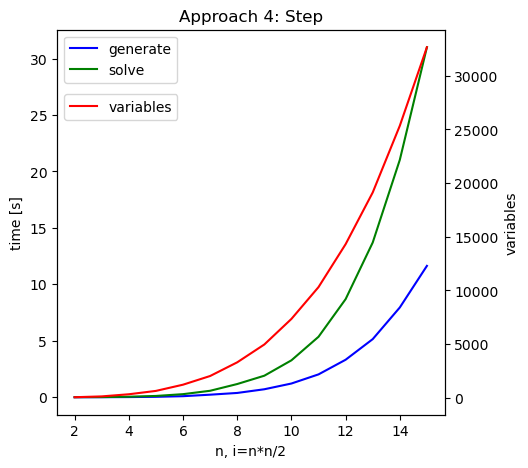

In [7]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax2 = ax.twinx()
ax.plot(step_result.index.tolist(),step_result['gen_problem'], color='b', label='generate')
ax.plot(step_result.index.tolist(),step_result['gen_solve'], color='g', label='solve')
ax2.plot(step_result.index.tolist(),step_result['gen_variables'], color='r', label='variables')
ax.set_xlabel('n, i=n*n/2')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('time [s]')
ax2.set_ylabel('variables')
ax.set_title('Approach 4: Step')
ax.grid(False)
ax.legend(loc="upper left")
ax2.legend(loc="upper left", bbox_to_anchor=(0.0, 0.85))
plt.savefig('./results/step_perf.eps',format='eps', bbox_inches='tight')

### SMT

In [2]:
# parameters for test
tests = range(2,11)
reps = 3
gen_problem_res = []
gen_solve = []
gen_variables = []

In [3]:
# generate and solve problem
for i in tqdm(tests):
    gen = gen_smt.Generator_grid(length=int(i**2/2), grid_size=(i, i))
    t = repeat(lambda: gen.generate_problem(), number=1, repeat=reps)
    gen_problem_res.append(np.mean(t))
    t = repeat(lambda: gen.get_solution(), number=1, repeat=reps)
    gen_solve.append(np.mean(t))
    vars = len(get_free_variables(And(gen.problem)))
    atoms = len(get_atoms(And(gen.problem)))
    gen_variables.append(vars)
    if vars != atoms:
        print(f'VARS != atoms for {i}')

 33%|███▎      | 3/9 [00:00<00:00, 18.40it/s]

VARS != atoms for 2
VARS != atoms for 3
VARS != atoms for 4
VARS != atoms for 5


 56%|█████▌    | 5/9 [00:03<00:03,  1.22it/s]

VARS != atoms for 6


 67%|██████▋   | 6/9 [00:10<00:07,  2.34s/it]

VARS != atoms for 7


 78%|███████▊  | 7/9 [00:43<00:21, 10.66s/it]

VARS != atoms for 8


 89%|████████▉ | 8/9 [01:49<00:25, 25.98s/it]

VARS != atoms for 9


100%|██████████| 9/9 [12:15<00:00, 81.72s/it] 

VARS != atoms for 10


In [4]:
smt_result = pd.DataFrame({'gen_problem': gen_problem_res, 'gen_solve': gen_solve, 'gen_variables': gen_variables}, index=tests)
smt_result.to_csv('./results/smt_perf.csv')
smt_result

,gen_problem,gen_solve,gen_variables
2,0.000461,0.006879,16
3,0.000937,0.008006,25
4,0.002361,0.027658,36
5,0.005221,0.056304,49
6,0.011134,0.983237,64
7,0.021333,2.177953,81
8,0.040035,10.970203,100
9,0.070614,21.682559,121
10,0.118642,208.462536,144


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


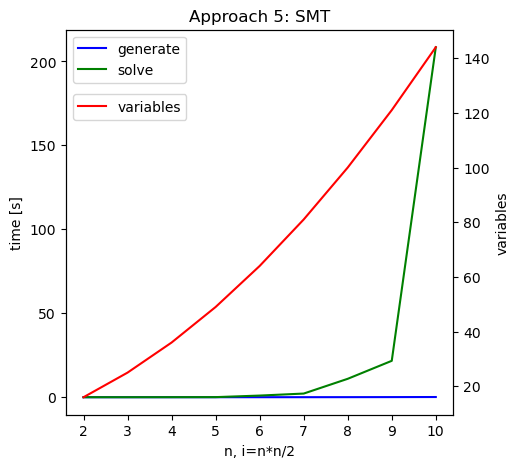

In [5]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax2 = ax.twinx()
ax.plot(smt_result.index.tolist(),smt_result['gen_problem'], color='b', label='generate')
ax.plot(smt_result.index.tolist(),smt_result['gen_solve'], color='g', label='solve')
ax2.plot(smt_result.index.tolist(),smt_result['gen_variables'], color='r', label='variables')
ax.set_xlabel('n, i=n*n/2')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('time [s]')
ax2.set_ylabel('variables')
ax.set_title('Approach 5: SMT')
ax.grid(False)
ax.legend(loc="upper left")
ax2.legend(loc="upper left", bbox_to_anchor=(0.0, 0.85))
plt.savefig('./results/smt_perf.eps',format='eps', bbox_inches='tight')

## Variable Plot

## Randomness

### Kripke

In [17]:
def draw_track(pieces: list, start: tuple, result_grid):
    """draw every piece"""
    angles = [0, 90, 180, 270]
    current_angle = 0  # list index for angles
    current_position = start
    PIECESIZE=1
    for p in pieces:
        typ = p[0]  # extract type of piece

        result_grid[current_position] += 1

        # calculate next position of piece based on angle
        # we only need to update angle if we go left or right
        if typ == 'l':
            if current_angle == 0:
                current_angle = 3
            else:
                current_angle -= 1
        if typ == 'r':
            if current_angle == 3:
                current_angle = 0
            else:
                current_angle += 1

        if angles[current_angle] == 0:
            # go up
            current_position = (current_position[0], current_position[1] - PIECESIZE)
        if angles[current_angle] == 180:
            # go down
            current_position = (current_position[0], current_position[1] + PIECESIZE)
        if angles[current_angle] == 90:
            # go left
            current_position = (current_position[0] + PIECESIZE, current_position[1])
        if angles[current_angle] == 270:
            # go right
            current_position = (current_position[0] - PIECESIZE, current_position[1])
    return result_grid

In [46]:
# parameters for test
size = (7,7)

# set up generator
gen = gen_kripke.Generator(length=25)
gen.generate_problem()

In [47]:
# grid to save values
grid = np.zeros((50,50), dtype=int)

for i in range(100):
    sol = gen.get_true_literals(method='reset')
    g = draw_track(sol, start=(25,25), result_grid=np.zeros(grid.shape, dtype=int))
    grid += g

In [48]:
g_new = grid[16:34, 16:34]

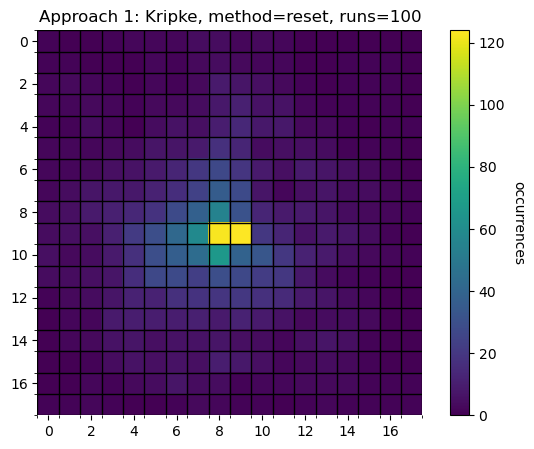

In [49]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(g_new)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(g_new.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(g_new.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 1: Kripke, method=reset, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/kripke_rand_reset.eps',format='eps', bbox_inches='tight')

In [50]:
# grid to save values
grid = np.zeros((50,50), dtype=int)

for i in range(100):
    sol = gen.get_true_literals(method='add')
    g = draw_track(sol, start=(25,25), result_grid=np.zeros(grid.shape, dtype=int))
    grid += g

In [51]:
g_new = grid[16:34, 16:34]

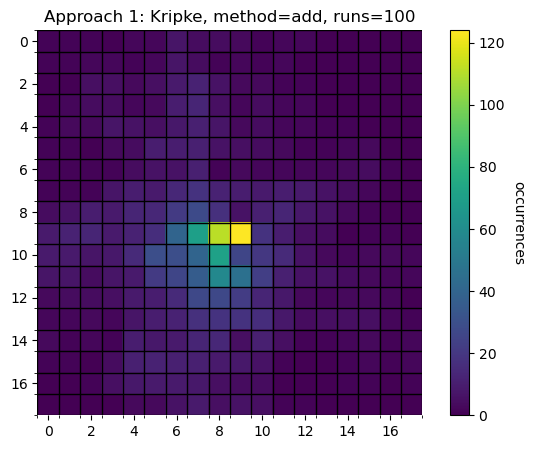

In [52]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(g_new)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(g_new.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(g_new.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 1: Kripke, method=add, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/kripke_rand_add.eps',format='eps', bbox_inches='tight')

### Exit

In [2]:
# parameters for test
size = (7,7)

# set up generator
gen = gen_exit.Generator_grid(grid_size=size)
gen.generate_problem()

In [3]:
# grid to save values
grid = np.zeros(gen.grids['STREET'].shape, dtype=int)

# run test
for i in tqdm(range(100)):
    sol = gen.get_random_sol(And(gen.problem), method='reset', getall=False, seed=np.random.randint(100))
    true_values = list(itertools.filterfalse(lambda x: x[1].constant_value() is False, sol))
    temp = np.zeros(gen.grids['STREET'].shape, dtype=int)
    for l in true_values:
        pos = gen._extract_pos(l[0])
        temp[pos] = 1
    grid += temp

100%|██████████| 100/100 [00:02<00:00, 34.81it/s]


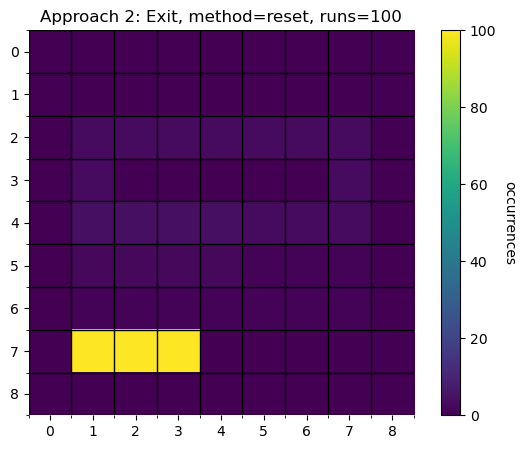

In [4]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(grid)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(grid.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(grid.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 2: Exit, method=reset, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/exit_rand_reset.eps',format='eps', bbox_inches='tight')

In [5]:
# grid to save values
grid = np.zeros(gen.grids['STREET'].shape, dtype=int)

sol = gen.get_random_sol(And(gen.problem), method='add', getall=True, maxsol=100, seed=np.random.randint(100))
for s in tqdm(sol):
    true_values = list(itertools.filterfalse(lambda x: x[1].constant_value() is False, s))
    temp = np.zeros(gen.grids['STREET'].shape, dtype=int)
    for l in true_values:
        pos = gen._extract_pos(l[0])
        temp[pos] = 1
    grid += temp

100%|██████████| 101/101 [00:00<00:00, 4391.21it/s]


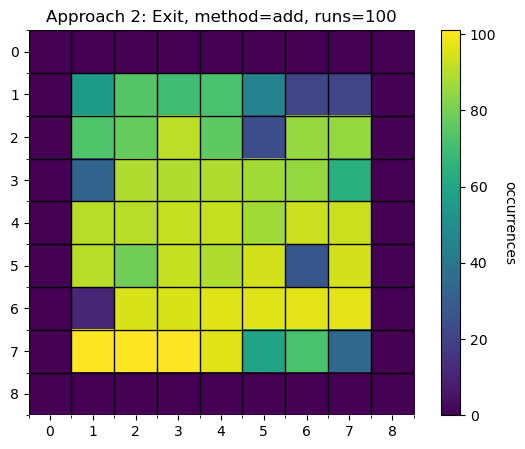

In [6]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(grid)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(grid.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(grid.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 2: Exit, method=add, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/exit_rand_add.eps',format='eps', bbox_inches='tight')

### Step

In [2]:
# parameters for test
size = (7,7)

# set up generator
gen = gen_step.Generator_grid(grid_size=size, length=int(7**2/2))
gen.generate_problem()

In [3]:
# grid to save values
grid = np.zeros(gen.grids['STREET'].shape, dtype=int)

# run test
for i in tqdm(range(100)):
    sol = gen.get_random_sol(And(gen.problem), method='reset', getall=False, seed=np.random.randint(100))
    true_values = list(itertools.filterfalse(lambda x: x[1].constant_value() is False, sol))
    temp = np.zeros(gen.grids['STREET'].shape, dtype=int)
    for l in true_values:
        pos = gen._extract_pos(l[0])
        temp[pos] = 1
    grid += temp

100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


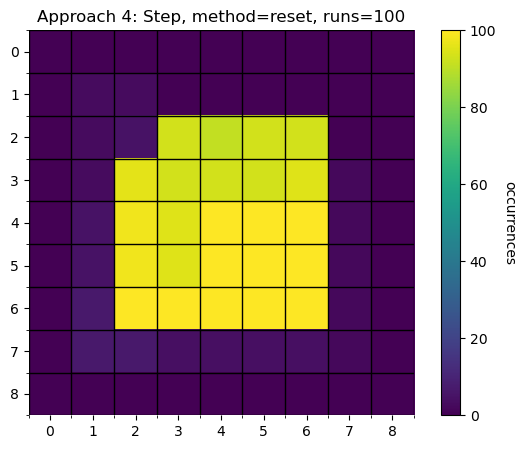

In [4]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(grid)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(grid.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(grid.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 4: Step, method=reset, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/step_rand_reset.eps',format='eps', bbox_inches='tight')

In [5]:
# grid to save values
grid = np.zeros(gen.grids['STREET'].shape, dtype=int)

sol = gen.get_random_sol(And(gen.problem), method='add', getall=True, maxsol=100, seed=np.random.randint(100))
for s in tqdm(sol):
    true_values = list(itertools.filterfalse(lambda x: x[1].constant_value() is False, s))
    temp = np.zeros(gen.grids['STREET'].shape, dtype=int)
    for l in true_values:
        pos = gen._extract_pos(l[0])
        temp[pos] = 1
    grid += temp

100%|██████████| 101/101 [00:00<00:00, 1311.70it/s]


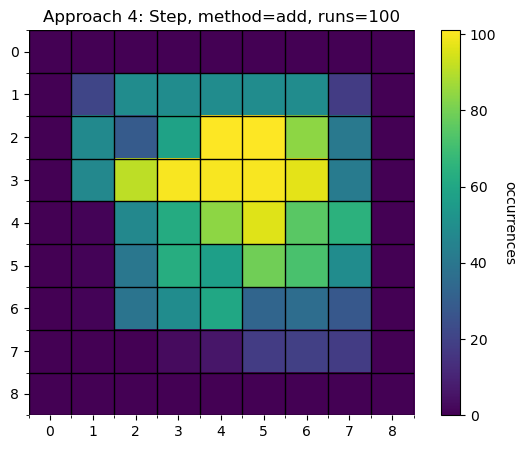

In [6]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(grid)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(grid.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(grid.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 4: Step, method=add, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/step_rand_add.eps',format='eps', bbox_inches='tight')

### SMT

In [2]:
# parameters for test
size = (7,7)

# set up generator
gen = gen_smt.Generator_grid(grid_size=size, length=int(7**2/2))
gen.generate_problem()

In [3]:
# grid to save values
grid = np.zeros(gen.grids['STREET'].shape, dtype=int)

# run test
for i in tqdm(range(100)):
    sol = gen.get_random_sol(And(gen.problem), method='reset', getall=False, seed=np.random.randint(100))
    temp = np.zeros(gen.grids['STREET'].shape, dtype=int)
    for l in sol:
        pos = gen._extract_pos(l[0])
        constant = l[1].constant_value()
        temp[pos] = 1 if constant > 0 else 0
    grid += temp

100%|██████████| 100/100 [04:11<00:00,  2.51s/it]


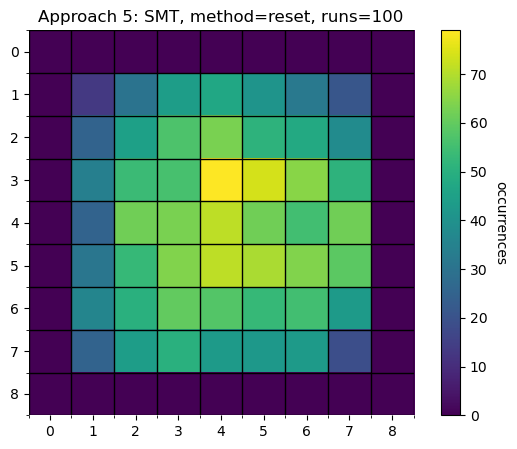

In [4]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(grid)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(grid.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(grid.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 5: SMT, method=reset, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/smt_rand_reset.eps',format='eps', bbox_inches='tight')

In [5]:
# grid to save values
grid = np.zeros(gen.grids['STREET'].shape, dtype=int)

sol = gen.get_random_sol(And(gen.problem), method='add', getall=True, maxsol=100, seed=np.random.randint(100))
for s in tqdm(sol):
    temp = np.zeros(gen.grids['STREET'].shape, dtype=int)
    for l in s:
        pos = gen._extract_pos(l[0])
        constant = l[1].constant_value()
        temp[pos] = 1 if constant > 0 else 0
    grid += temp

100%|██████████| 101/101 [00:00<00:00, 10102.18it/s]


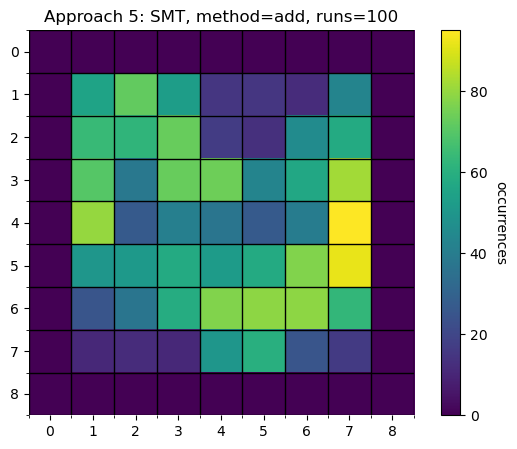

In [6]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = ax.imshow(grid)
ax.spines[:].set_visible(False)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
ax.set_xticks(np.arange(grid.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(grid.shape[0]+1)-.5, minor=True)
ax.set_title('Approach 5: SMT, method=add, runs=100')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('occurrences', rotation=-90, va="bottom")
plt.savefig('./results/smt_rand_add.eps',format='eps', bbox_inches='tight')